In [1]:
from utils import *
from modeling import *
from plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = 3100, 1400, 4100, 2400   # image coords
# patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = (3000, 1400, 4200, 2600)

image_size = 800
pixel_scale = 2.5                                # arcsec/pixel

In [80]:
# PSF Parameters
beta = 10                                     # moffat beta, in arcsec
fwhm = 2.28 * pixel_scale                     # moffat fwhm, in arcsec

n0 = 3.27                    # estimated true power index
theta_0 = 5.                # radius at which power law is flattened, in arcsec (arbitrary)

n_s = np.array([n0, 2.35, 1.35, 4])                   # power index
theta_s = np.array([theta_0, 10**1.85, 10**2.18, 1200])      # transition radius in arcsec

# Multi-power PSF
frac = 0.3

params_mpow = {"fwhm":fwhm, "beta":beta, "frac":frac, "n_s":n_s, 'theta_s':theta_s}
psf = PSF_Model(params=params_mpow, aureole_model='multi-power')

# Build grid of image for drawing
psf.make_grid(image_size, pixel_scale=pixel_scale)

In [51]:
############################################
# Read
############################################

hdu = fits.open("./data/coadd_SloanG_NGC_5907.fits")[0]
data = hdu.data
header = hdu.header

# Backgroundlevel and estimated std
mu, sigma = 458.76, 10**0.33
ZP = np.float(hdu.header["REFZP"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, sigma, ZP, pixel_scale))

# Crop image
pad = ((patch_Xmax0-patch_Xmin0)-image_size)//2
patch_Xmin, patch_Ymin = patch_Xmin0 + pad, patch_Ymin0 + pad
patch_Xmax, patch_Ymax = patch_Xmax0 - pad, patch_Ymax0 - pad

image_bounds0 = (patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0)
image_bounds = (patch_Xmin, patch_Ymin, patch_Xmax, patch_Ymax)
patch0, seg_patch0 = crop_image(data, image_bounds0, draw=False)

# Read measurement for faint stars from catalog
tab_catalog = Table.read("./Measure/NGC5907-G-catalog_PS_X%sY%s.txt"\
                       %(patch_Xmin0,patch_Ymin0), format="ascii")
tab_faint = tab_catalog[(tab_catalog["rmag"]>=15) & (tab_catalog["rmag"]<22)]
tab_faint = crop_catalog(tab_faint, keys=("X_IMAGE_PS", "Y_IMAGE_PS"),
                         bounds=(patch_Xmin,patch_Ymin,patch_Xmax,patch_Ymax))
tab_faint["FLUX_AUTO"] = 10**((tab_faint["GMAG_AUTO"]-ZP)/(-2.5))

# Read measurement for bright stars
R_scale = 12
table_res_Rnorm = Table.read("./Measure/NGC5907-G-norm_%dpix_r15mag_X%dY%d.txt"\
                             %(R_scale, patch_Xmin0, patch_Ymin0), format="ascii")
table_res_Rnorm = crop_catalog(table_res_Rnorm, bounds=image_bounds0)

mu: 458.76 , std: 2.14 , ZP: 27.10 , pix_scale: 2.50


Threosholds: [27.  23.5] [ 290611.95460878 7299842.25616276] [  6.8287563  171.53060282]
# of medium bright (flux:2.9e+05~3.2e+06) stars: 45 
# of very bright (flux>2e+07) stars : 3
Not many bright stars, will draw in serial.



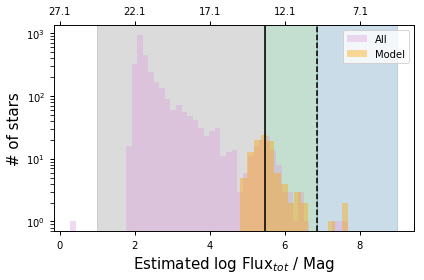

In [81]:
# Star Distribution
############################################
# Positions & Flux of faint stars from SE
ma = tab_faint['FLUX_AUTO'].data.mask
star_pos1 = np.vstack([tab_faint['X_IMAGE_PS'].data[~ma],
                       tab_faint['Y_IMAGE_PS'].data[~ma]]).T - [patch_Xmin, patch_Ymin]
Flux1 = np.array(tab_faint['FLUX_AUTO'].data[~ma])

# Positions & Flux (estimate) of faint stars from measured norm
star_pos2 = np.vstack([table_res_Rnorm['X_IMAGE'],
                       table_res_Rnorm['Y_IMAGE']]).T - [patch_Xmin, patch_Ymin]
# sky_local = np.median(table_res_Rnorm['sky'].data)

# Estimate of brightness I at r_scale (I = Intensity - BKG) and flux
z_norm = table_res_Rnorm['Imean'].data - mu
Flux2 = psf.I2Flux(z_norm, r=R_scale)

# Thresholds
SB_threshold = np.array([27.,23.5])
Flux_threshold = psf.SB2Flux(SB_threshold, BKG=mu, ZP=ZP, r=R_scale)
z_threshold = psf.Flux2I(Flux_threshold, r=R_scale)
print("Threosholds:", SB_threshold, Flux_threshold, z_threshold)

# Combine 
star_pos = np.vstack([star_pos1, star_pos2])
Flux = np.concatenate([Flux1, Flux2])
stars_all = Stars(star_pos, Flux, Flux_threshold=Flux_threshold)
stars_all.plot_flux_dist(label='All', color='plum')

# Bright stars in model
stars0 = Stars(star_pos2, Flux2, Flux_threshold=Flux_threshold,
               z_norm=z_norm, r_scale=R_scale, BKG=mu)
stars0 = stars0.remove_outsider(image_size, d=[24, 6], verbose=True)
stars0.plot_flux_dist(label='Model', color='orange', ZP=ZP)

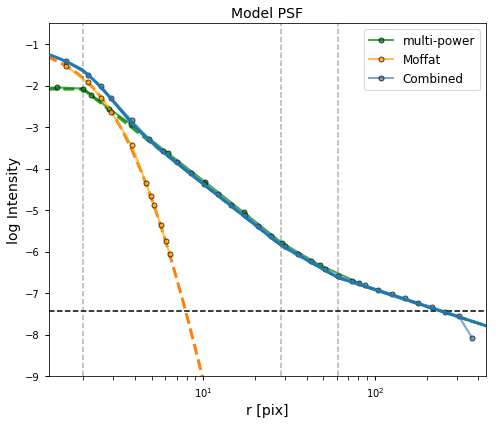

In [82]:
# Generate core and aureole PSF
psf_c = psf.generate_core()
psf_e, psf_size = psf.generate_aureole(contrast=1e6, psf_range=image_size)
star_psf = (1-frac) * psf_c + frac * psf_e

# Galsim 2D model averaged in 1D
Amp_m = psf.Flux2Amp(Flux).max()
psf.plot_model_galsim(contrast=Amp_m / sigma)

In [83]:
# Setup Image
############################################
# Make noise image
noise_image = make_noise_image(image_size, sigma)

# Make sky background and dim stars
image_base = make_base_image(image_size, stars_all, psf_base=star_psf, psf_size=128, pad=pad, verbose=True)

# Cutout of data
image0 = patch0.copy()
image = image0[pad:-pad,pad:-pad]

Generate noise background w/ stddev = 2.14
Generate base image of faint stars (flux < 2.9e+05).
Total Time: 11.786 s



Fit vs Data

In [84]:
image_fit0 = generate_image_by_znorm(psf, stars0, psf_range=[600,1200], brightest_only=False,
                                     psf_scale=pixel_scale, parallel=False, draw_real=True)
image_fit = image_fit0 + image_base + mu + noise_image

Detect and deblend source... Mask S/N > 3.0 (5th enlarged)
Use mask map built from catalog
Mask core regions: r < 36 (24) pix 
Use sky strips crossing very bright stars


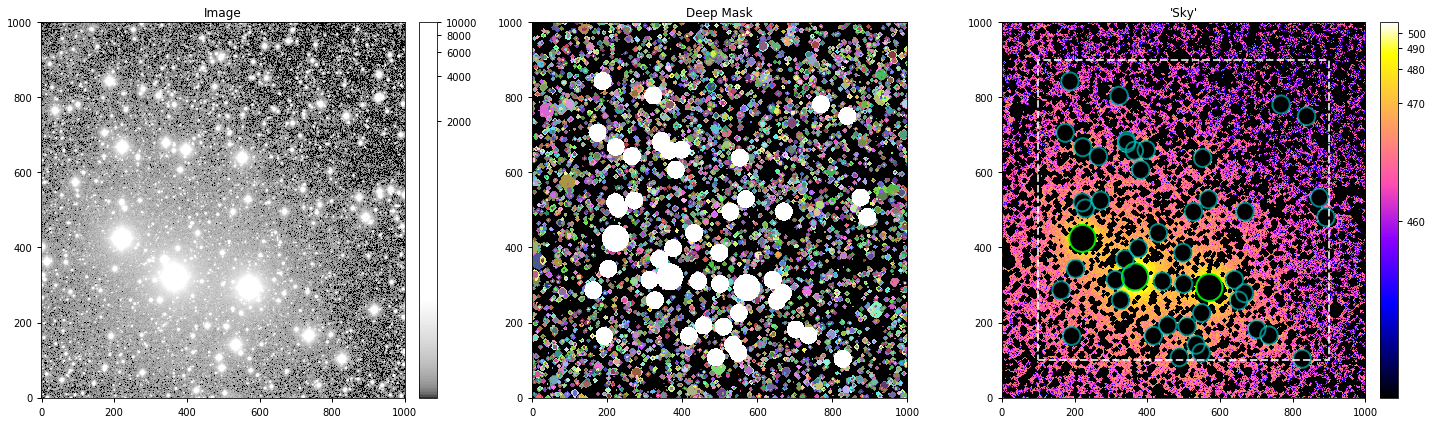

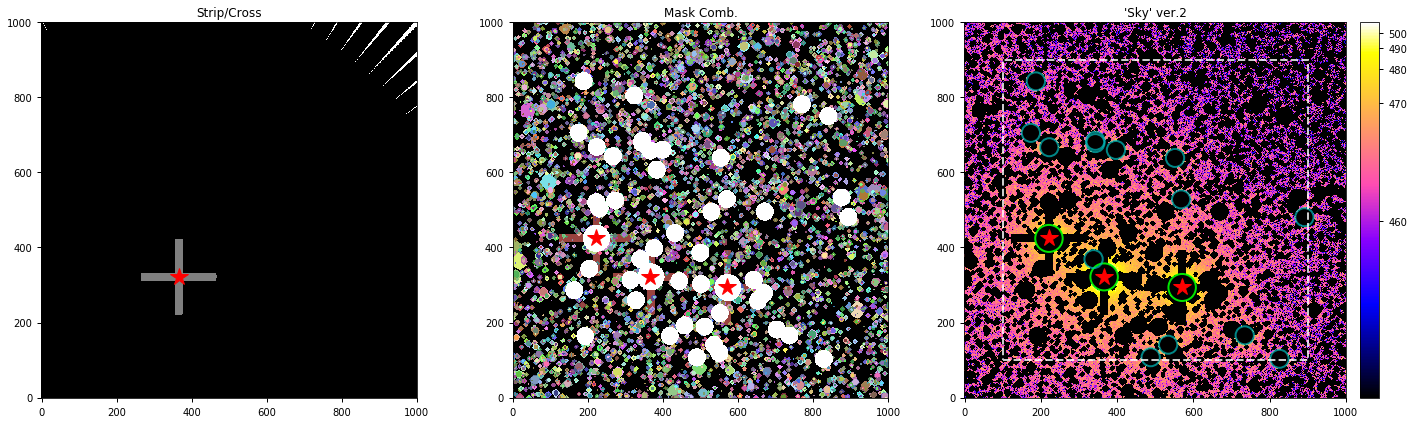

In [58]:
mask = Mask(image0, stars0, image_size, pad=100, mu=mu)
r_core_s = [36, 24]

mask_base = "./Measure/Seg_PS_X%dY%d.fits" %(patch_Xmin0, patch_Ymin0)
mask.make_mask_map_dual(r_core_s, mask_base=mask_base,
                        sn_thre=3, draw=True, n_dilation=5)

# Strip + Cross mask
mask.make_mask_strip(24, 48, dist_strip=1000, clean=True,draw=True)

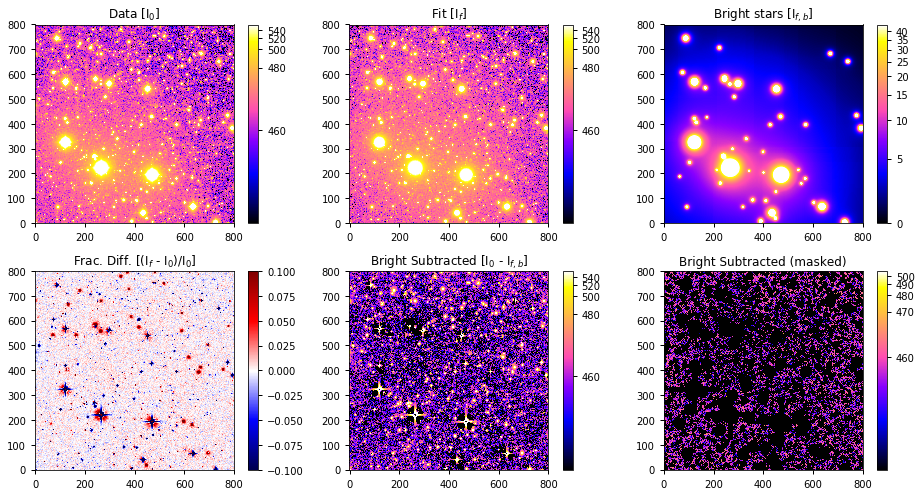

In [79]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(13,7))
im = ax1.imshow(image, vmin=457.5, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax1.set_title("Data [I$_0$]"); colorbar(im)
im = ax2.imshow(image_fit, vmin=457.5, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
ax2.set_title("Fit [I$_f$]"); colorbar(im)
im = ax3.imshow(image_fit0, vmin=0, vmax=44, norm=norm0, cmap="gnuplot2")    
ax3.set_title("Bright stars [I$_{f,b}$]"); colorbar(im)
im = ax4.imshow((image_fit-image)/image, vmin=-0.1, vmax=0.1, cmap="seismic")
ax4.set_title("Frac. Diff. [(I$_f$ - I$_0$)/I$_0$]"); colorbar(im)
residual = (image-image_fit0)
im = ax5.imshow((image-image_fit0), vmin=457.5, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax5.set_title("Bright Subtracted [I$_0$ - I$_{f,b}$]"); colorbar(im)
residual[mask.mask_comb] = 0
im = ax6.imshow(residual, vmin=457.5, vmax=mu+50, norm=norm2, cmap="gnuplot2")
ax6.set_title("Bright Subtracted (masked)"); colorbar(im)
plt.tight_layout()
plt.savefig("Pics/PSF_Fit2.png",dpi=120)

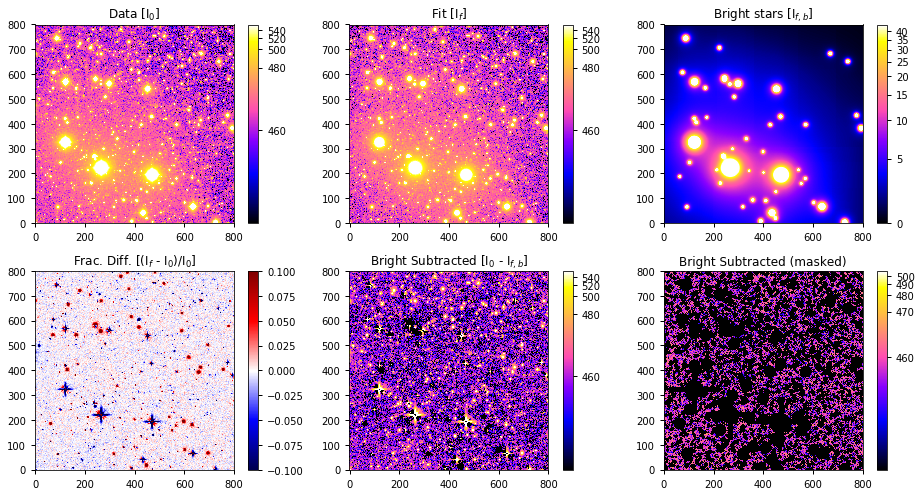

In [85]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3,figsize=(13,7))
im = ax1.imshow(image, vmin=457.5, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax1.set_title("Data [I$_0$]"); colorbar(im)
im = ax2.imshow(image_fit, vmin=457.5, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
ax2.set_title("Fit [I$_f$]"); colorbar(im)
im = ax3.imshow(image_fit0, vmin=0, vmax=44, norm=norm0, cmap="gnuplot2")    
ax3.set_title("Bright stars [I$_{f,b}$]"); colorbar(im)
im = ax4.imshow((image_fit-image)/image, vmin=-0.1, vmax=0.1, cmap="seismic")
ax4.set_title("Frac. Diff. [(I$_f$ - I$_0$)/I$_0$]"); colorbar(im)
residual = (image-image_fit0)
im = ax5.imshow((image-image_fit0), vmin=457.5, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax5.set_title("Bright Subtracted [I$_0$ - I$_{f,b}$]"); colorbar(im)
residual[mask.mask_comb] = 0
im = ax6.imshow(residual, vmin=457.5, vmax=mu+50, norm=norm2, cmap="gnuplot2")
ax6.set_title("Bright Subtracted (masked)"); colorbar(im)
plt.tight_layout()
plt.savefig("Pics/PSF_Fit1.png",dpi=120)

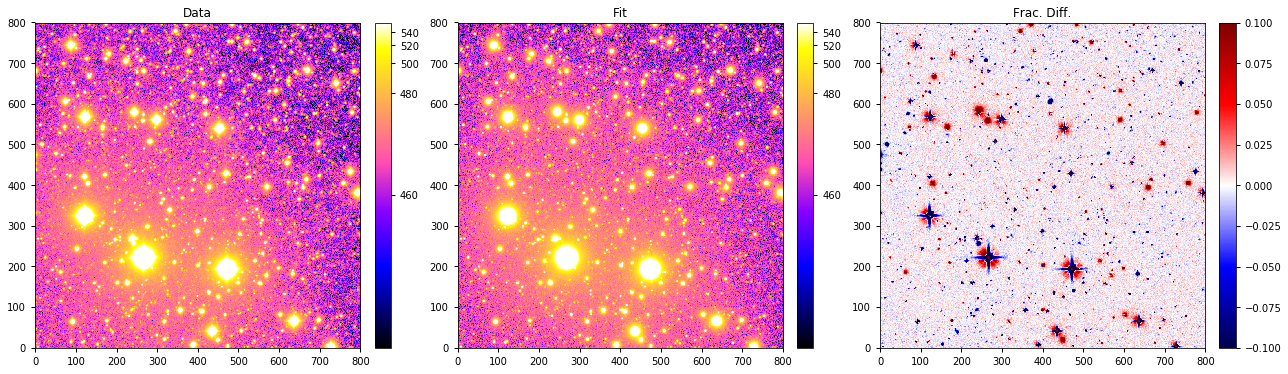

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6))
im = ax1.imshow(image, vmin=mu-1, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax1.set_title("Data"); colorbar(im)
im = ax2.imshow(image_fit, vmin=mu-1, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
ax2.set_title("Fit"); colorbar(im)
im = ax3.imshow((image_fit-image)/image, vmin=-0.1, vmax=0.1, cmap="seismic")
ax3.set_title("Frac. Diff."); colorbar(im)
plt.tight_layout()
# plt.savefig("Pics/PSF_FitvsData2.png",dpi=120)

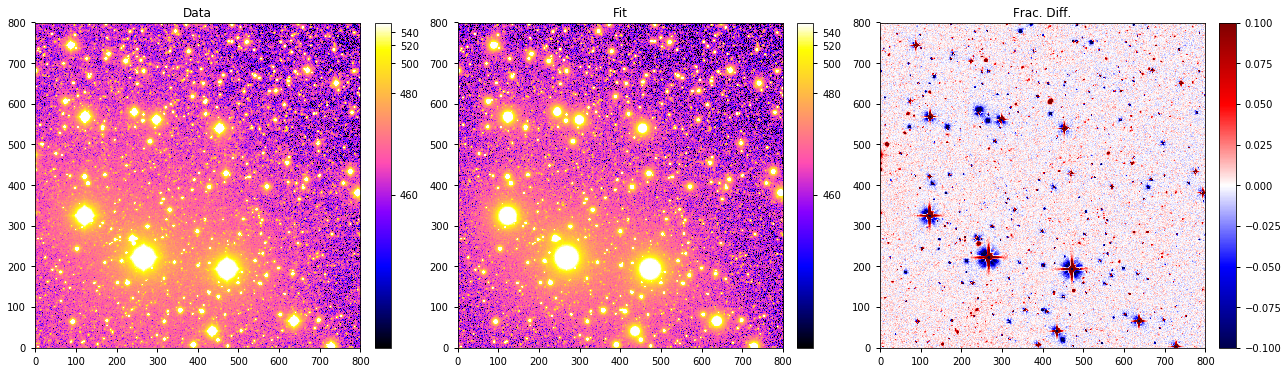

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6))
im = ax1.imshow(image, vmin=mu-1, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax1.set_title("Data"); colorbar(im)
im = ax2.imshow(image_fit, vmin=mu-1, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
ax2.set_title("Fit"); colorbar(im)
im = ax3.imshow((image-image_fit)/image, vmin=-0.1, vmax=0.1, cmap="seismic")
ax3.set_title("Frac. Diff."); colorbar(im)
plt.tight_layout()
# plt.savefig("Pics/PSF_FitvsData2.png",dpi=120)

### Joint PSF

/home/qliu/Desktop/PSF/utils.py:439: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(r[r>3*r_core], np.log10(z[r>3*r_core]), color=color, s=3, alpha=0.1, zorder=1)


(-8, -0.5)

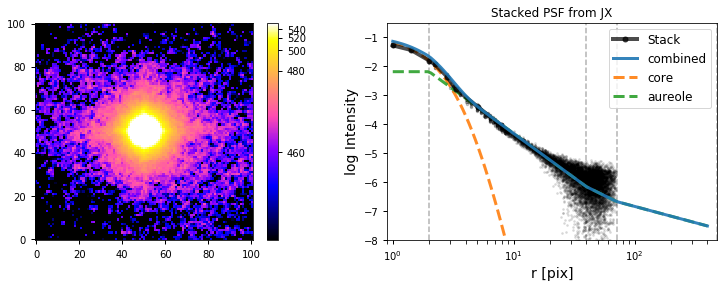

In [22]:
PSF_JX = fits.getdata("./med_psf_JX.fits") * 10 + mu

fig = plt.figure(figsize=(13,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX, norm=norm1, vmin=mu); colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(abs(PSF_JX-mu)/1e6, cen=(50,50), 
                                              ZP=ZP, sky_mean=0, sky_std=1e-6,
                                              dr=1, lw=4, pixel_scale=pixel_scale,
                                              xunit="pix", yunit="Intensity", color="k", label='Stack',
                                              scatter=True, core_undersample=True)
plt.title("Stacked PSF from JX")
psf.plot1D()
plt.xlim(0.9, 480)
plt.ylim(-8, -0.5)

479.6526486086847 3.0046067542185577


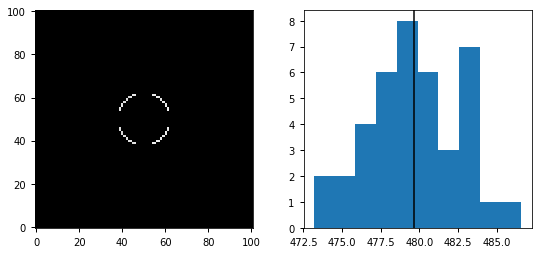

In [23]:
I_mean_stack, I_med_stack, I_std_stack, flag = compute_Rnorm(PSF_JX, np.zeros_like(PSF_JX, dtype=bool), cen=[50,50],
                                                             R=R_scale, mask_cross=True, display=True)
print(I_mean_stack, I_std_stack)

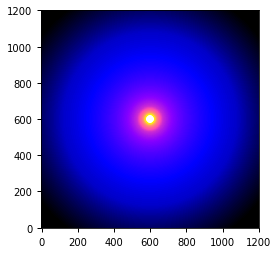

In [55]:
n_s = psf.n_s
theta_s = psf.theta_s

psf_size = 1201

cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]
rr_psf = np.sqrt((xx_psf-cen_psf[0])**2+(yy_psf-cen_psf[1])**2)
rr_psf[rr_psf<1] = 1

theta_s_pix = theta_s / pixel_scale
psf_model = multi_power2d(xx_psf, yy_psf, n_s, theta_s_pix, 1, cen=cen_psf) 
plt.imshow(psf_model, vmin=1e-6, vmax=1e-3, norm=norm1)

l_cut = 12
mask_field=np.zeros_like(psf_model, dtype=bool)
I_mean_psf, I_med_psf, I_std_psf, flag = compute_Rnorm(psf_model, mask_field, cen=cen_psf,
                                                       R=R_scale, mask_cross=False, display=False)

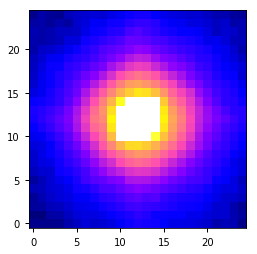

In [56]:
l_min, l_max = 101//2-l_cut, 101//2+l_cut+1
PSF_stack_cutout = (PSF_JX[l_min:l_max, l_min:l_max].copy()-mu)/((I_mean_stack-mu)/I_mean_psf)
plt.imshow(PSF_stack_cutout, vmin=1e-7, vmax=1, norm=norm1)

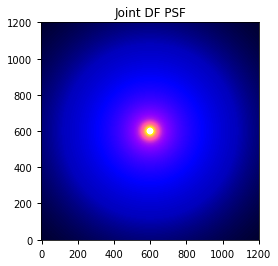

In [57]:
min_joint, max_joint = psf_size//2-l_cut, psf_size//2+l_cut+1
psf_joint_model = psf_model.copy()
psf_joint_model[min_joint:max_joint, min_joint:max_joint] = PSF_stack_cutout
psf_joint_model /= psf_joint_model.sum()
plt.imshow(psf_joint_model, vmin=1e-9, vmax=1e-5, norm=norm1)
plt.title("Joint DF PSF")

hdu_joint = fits.ImageHDU(psf_joint_model)
hdu_joint.writeto('./real/Joint_PSF_DF.fits', overwrite=True)

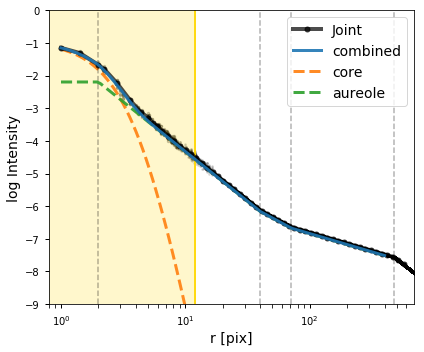

In [58]:
plt.figure(figsize=(6,5))
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(psf_joint_model, cen=cen_psf, 
                                              ZP=ZP, sky_mean=0, sky_std=1e-8,
                                              dr=1.2, lw=4, pixel_scale=pixel_scale,
                                              xunit="pix", yunit="Intensity",
                                              color="k", label='Joint',
                                              scatter=True, core_undersample=True)
psf.plot1D()

plt.legend(loc=1, fontsize=14, columnspacing=0.5, framealpha=0.8)
plt.fill_betweenx([-10, 0.], x1=0, x2=l_cut, color="gold", alpha=0.2)
plt.axvline(R_scale, lw=2, color="gold", alpha=0.9)
plt.ylim(-9,0)
plt.tight_layout()
# plt.savefig("Pics/Joint_PSF.png",dpi=120)

In [ ]:
# psf_joint_model = fits.getdata('./real/Joint_PSF_DF.fits')

In [59]:
image_psf = galsim.ImageF(psf_joint_model)
psf_joint = galsim.InterpolatedImage(image_psf, flux=1, scale=pixel_scale)

In [60]:
start = time.time()

full_image0 = galsim.ImageF(image_size, image_size)

star_pos_bright = stars0.star_pos_bright
# Flux_bright = stars0.Flux_bright

I_ext = psf.calculate_external_light(stars0)
z_norm_bright = stars0.z_norm_bright.copy()
z_norm_bright -= I_ext
Flux_bright = psf.I2Flux(z_norm_bright, stars0.r_scale)

# draw faint stars in Moffat with galsim in Fourier space   
for k in range(len(star_pos_bright)):
    try:
        draw_star(k, star_pos=star_pos_bright, Flux=Flux_bright,
                  psf_star=psf_joint, psf_size=1200, full_image=full_image0)
    except GalSimBoundsError as e:
        if verbose:
            print(e.__doc__)
            print(e.message)
        continue

image_joint = full_image0.array

end = time.time()
print("Total Time: %.3f s\n"%(end-start))

image_joint += image_base + mu + noise_image

/home/qliu/Desktop/PSF/modeling.py:1019: RuntimeWarning: divide by zero encountered in true_divide
  I_s = I0_s / r_s**(n_s[r_inds]) / theta_s[0]**(-n_s[0])


Total Time: 8.885 s



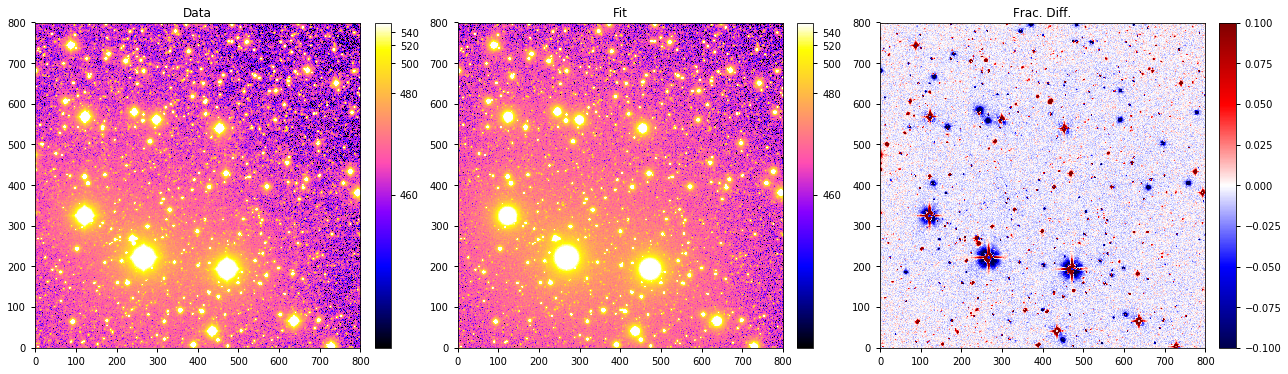

In [61]:
image_joint[image_joint>5e4] = 5e4
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(18,6))
im = ax1.imshow(image, vmin=mu-1, vmax=mu+100, norm=norm1, cmap="gnuplot2")
ax1.set_title("Data"); colorbar(im)
im = ax2.imshow(image_joint, vmin=mu-1, vmax=mu+100, norm=norm1, cmap="gnuplot2")    
ax2.set_title("Fit"); colorbar(im)
im = ax3.imshow((image-image_joint)/image, vmin=-0.1, vmax=0.1, cmap="seismic")
ax3.set_title("Frac. Diff."); colorbar(im)
plt.tight_layout()
# plt.savefig("Pics/PSF_JointvsData2.png",dpi=120)

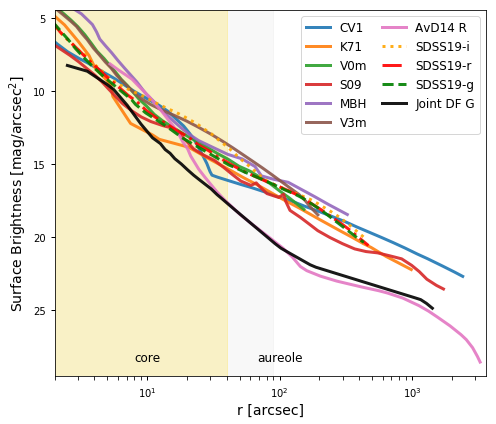

In [62]:
import pandas as pd
PSF_S14 = pd.read_csv("./web_digit/wpd_Sandin2014.csv", skiprows=1)
labels = ["CV1", "K71", "V0m", "S09", r"MBH", "V3m", 'AvD14 R']

PSF_SDSS19 = pd.read_csv("./web_digit/SDSS2019.csv", skiprows=1)
labels_SDSS = ["SDSS19-i", "SDSS19-r", "SDSS19-g"]

SB_rbin = Intensity2SB(z_rbin*3e9, BKG=0, ZP=ZP, pixel_scale=pixel_scale)

plt.figure(figsize=(7,6))

for k, lab in enumerate(labels):
    x, y = PSF_S14["X%d"%k], PSF_S14["Y%d"%k]
    y_sort = -2.5*y.reindex(np.argsort(x)) 
    x_sort = x.reindex(np.argsort(x))
    plt.semilogx(x_sort,y_sort, lw=3, alpha=0.9, label=lab)
    
for k, (lab,c,ls) in enumerate(zip(labels_SDSS,['orange','r','g'],[':','-.','--'])):
    x, y = PSF_SDSS19.iloc[:,k*2], PSF_SDSS19.iloc[:,k*2+1]
    y_sort = y.reindex(np.argsort(x))
    x_sort = x.reindex(np.argsort(x))
    plt.semilogx(x_sort,y_sort, color=c, lw=3, ls=ls, alpha=0.9, label=lab)
    
plt.semilogx(r_rbin*2.5, SB_rbin, lw=3, alpha=0.9, color='k', label="Joint DF G")

# plt.axhline(I_tot_12.min()+15-I_n,color="k",ls="--")
plt.legend(ncol=2, fontsize=12, columnspacing=1.2, framealpha=0.8)
plt.fill_betweenx([0, 32.], x1=0, x2=36*2.5, color="gray", alpha=0.05)
plt.fill_betweenx([0, 32.], x1=0, x2=16*2.5, color="gold", alpha=0.2)

plt.text(10,28.5,"core", ha='center', fontsize=12,color="k")
plt.text(100,28.5,"aureole", ha='center', fontsize=12,color="k")
plt.xlabel("r [arcsec]")
plt.ylabel("Surface Brightness [mag/arcsec$^2$]")        
plt.ylim(29.5, 4.5)
plt.xlim(2., 3600)
plt.tight_layout()
# plt.savefig("Pics/Joint_PSF_literature.png",dpi=120)

In [79]:
from scipy import interpolate
y_sort = y_sort[~np.isnan(x_sort)]
x_sort = x_sort[~np.isnan(x_sort)]
f = interpolate.interp1d(x_sort, 10**(y_sort/-2.5),
                         bounds_error=False, fill_value=(0.41,7e-9))
# f applies on arcsec

402.76386988911156


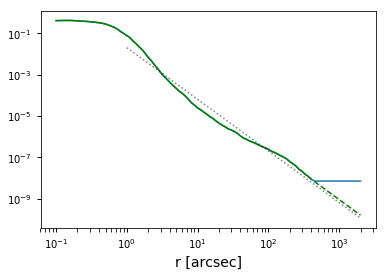

In [91]:
# extrapolate SDSS PSF
xp = np.logspace(-1, 3.3, 100)
yp = f(xp)
plt.loglog(xp, yp)

n_sdss = 2.5

yp2 = yp.copy()
x20 = xp[yp>7e-9].max() # in arcsec
print(x20)
yp20 = f(x20)
a = yp20 /x20**(-n_sdss)
yp2[yp<=7e-9] = a * xp[yp<=7e-9]**(-n_sdss)
plt.loglog(xp[yp>7e-9], yp2[yp>7e-9], color='g')
plt.loglog(xp[yp<=7e-9], yp2[yp<=7e-9], color='g', ls='--')
plt.xlabel('r [arcsec]')

x_ls = np.logspace(0,3.3)
plt.loglog(x_ls, 0.02*x_ls**-n_sdss, color='k', ls=':', alpha=0.5)

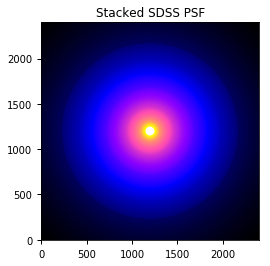

In [104]:
psf_size = 2401
k_scale = 6
pixel_scale_sdss = pixel_scale / k_scale

cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]
rr_psf = np.sqrt((xx_psf-cen_psf[0])**2+(yy_psf-cen_psf[1])**2)

psf_model_sdss0 = f(rr_psf.ravel()*pixel_scale_sdss).reshape(psf_size,-1)

x20_psf_pix = x20 / pixel_scale_sdss
yp20_psf = f(x20_psf_pix)
a_psf = yp20_psf /x20_psf_pix**(-n_sdss)
psf_model_sdss0[rr_psf>=x20_psf_pix] = a_psf * rr_psf[rr_psf>=x20_psf_pix]**(-n_sdss)

psf_model_sdss = psf_model_sdss0.copy()

psf_model_sdss /= psf_model_sdss.sum()
plt.imshow(psf_model_sdss, vmin=psf_model_sdss.min(), vmax=1e-6, norm=norm1)
plt.title("Stacked SDSS PSF")

hdu_sdss = fits.ImageHDU(psf_model_sdss)
hdu_sdss.writeto('./real/Stacked_PSF_SDSS.fits', overwrite=True)

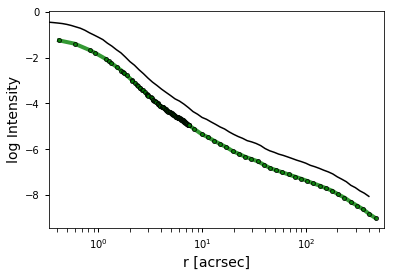

In [103]:
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(psf_model_sdss, cen=[1200, 1200], 
                                              ZP=0, sky_mean=0, sky_std=1e-9,
                                              dr=4, lw=4, pixel_scale=pixel_scale_sdss,
                                              xunit="arcsec", yunit="Intensity",
                                              color="g", label='SDSS-G band', alpha=0.8, 
                                              scatter=False, markersize=4, core_undersample=True)
plt.semilogx(xp[yp>7e-9], np.log10(yp2[yp>7e-9]), color='k')

In [39]:
# psf_model_sdss = fits.getdata('./real/Stacked_PSF_SDSS.fits')

In [106]:
image_psf_sdss = galsim.ImageF(psf_model_sdss)
psf_sdss = galsim.InterpolatedImage(image_psf_sdss, flux=1, scale=pixel_scale)

image_base_sdss = make_base_image(image_size, stars_all, psf_base=psf_sdss,
                                  pad=pad, psf_size=128, verbose=True)

Generate base image of faint stars (flux < 1.6e+05).
Total Time: 20.487 s



In [76]:
start = time.time()

full_image0 = galsim.ImageF(image_size, image_size)

star_pos_sdss = stars0.star_pos_bright
Flux_sdss = psf.I2Flux(stars0.z_norm_bright, r=R_scale)

# draw faint stars in Moffat with galsim in Fourier space   
for k in range(len(star_pos_sdss)):
    try:
        draw_star(k, star_pos=star_pos_sdss, Flux=Flux_sdss,
                  psf_star=psf_sdss, psf_size=1201, full_image=full_image0)
    except GalSimBoundsError as e:
        print(e.__doc__)
        print(e.message)
        continue

image_sdss = full_image0.array

end = time.time()
print("Total Time: %.3f s\n"%(end-start))

image_sdss0 = image_sdss.copy()
image_sdss += mu+noise_image+image_base_sdss

Total Time: 19.693 s



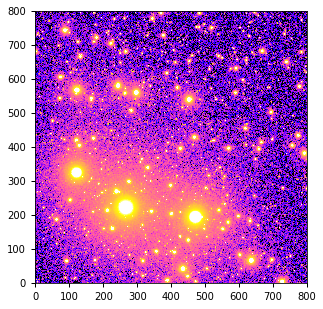

In [77]:
plt.figure(figsize=(5,5))
plt.imshow(image_sdss, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")

### Read SDSS mosaic and rescale 

In [64]:
w = wcs.WCS(header)
w.pixel_to_world([patch_Xmin+500], [patch_Ymin+500])

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    [(228.06839834, 56.23939449)]>

In [144]:
hdu_SDSS = fits.open("./SDSS_mosaic/J151216.00+561421.0-g.fits")[0]
SDSS_image0 = hdu_SDSS.data
header_SDSS = hdu_SDSS.header

from reproject import reproject_interp
SDSS_image_full, footprint = reproject_interp(hdu_SDSS, header)

SDSS_image0, seg_patch0 = crop_image(SDSS_image_full, image_bounds, sky_mean=mu, sky_std=sigma, draw=False)

In [157]:
q1=np.quantile((SDSS_image0[~np.isnan(SDSS_image0)]), 0.997)
q2=np.quantile(image_sdss0, 0.997)
print(q1,q2)

SDSS_image = (SDSS_image0) * q2/q1

m_SDSS = np.median(SDSS_image[~np.isnan(SDSS_image)])
s_SDSS = mad_std(SDSS_image[~np.isnan(SDSS_image)])
print(m_SDSS, s_SDSS)

11.680719608378157 760.4832753906542
2.5384640653107837 6.283995346045219


In [158]:
# Add same noise on mock SDSS image as mosaic
noise_img = make_noise_image(image_size, s_SDSS)

img_sdss0 = image_sdss0 + noise_img +image_base_sdss
m_img = np.median(img_sdss0)
s_img = mad_std(img_sdss0)

Generate noise background w/ stddev = 6.28


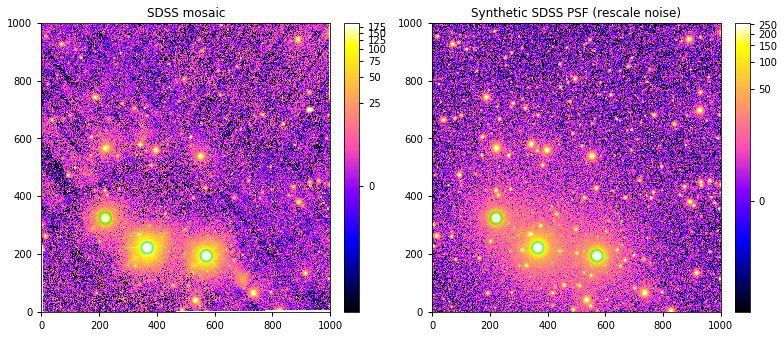

In [160]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))

im = ax1.imshow(SDSS_image, vmin=m_SDSS-s_SDSS, vmax=m_SDSS+30*s_SDSS, norm=norm1, cmap="gnuplot2")
ax1.set_title("SDSS mosaic"); colorbar(im)
im = ax2.imshow(img_sdss0, vmin=m_img-s_img, vmax=m_img+30*s_img, norm=norm2, cmap="gnuplot2")
ax2.set_title("Synthetic SDSS PSF (rescale noise)"); colorbar(im)

aper1 = CircularAperture(stars0.star_pos_verybright, r=20)
for ax in [ax1,ax2]:
    aper1.plot(color='lime',lw=2,alpha=0.6,axes=ax)
    
plt.tight_layout()
# plt.savefig("Pics/SDSS_mock_vs_mosaic2.png",dpi=120)

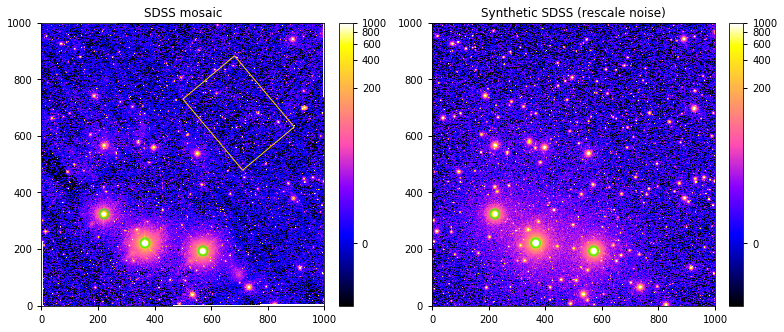

In [163]:
from matplotlib import patches

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
im = ax1.imshow(SDSS_image, vmin=-3.6, vmax=1000, norm=norm1, cmap="gnuplot2")
ax1.set_title("SDSS mosaic"); colorbar(im)
im = ax2.imshow(img_sdss0, vmin=-3.6, vmax=1000, norm=norm2, cmap="gnuplot2")
ax2.set_title("Synthetic SDSS (rescale noise)"); colorbar(im)

aper1 = CircularAperture(stars0.star_pos_verybright, r=16)
for ax in [ax1,ax2]:
    aper1.plot(color='lime',lw=2,alpha=0.6,axes=ax)

rec = patches.Rectangle((500,730),328,238, angle=-50, edgecolor="gold", facecolor="none")
ax1.add_patch(rec)

plt.tight_layout()
# plt.savefig("Pics/SDSS_mock_vs_mosaic.png",dpi=120)

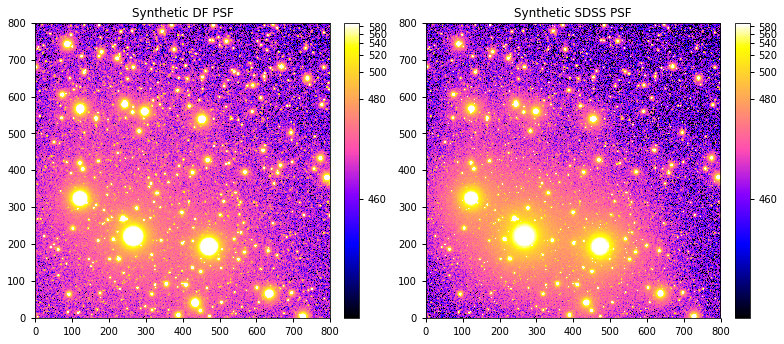

In [43]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))

im = ax1.imshow(image_fit, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax1.set_title("Synthetic DF PSF"); colorbar(im)
im = ax2.imshow(image_sdss, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax2.set_title("Synthetic SDSS PSF"); colorbar(im)

plt.tight_layout()
# plt.savefig("Pics/SDSSvsDF_mock.png",dpi=120)

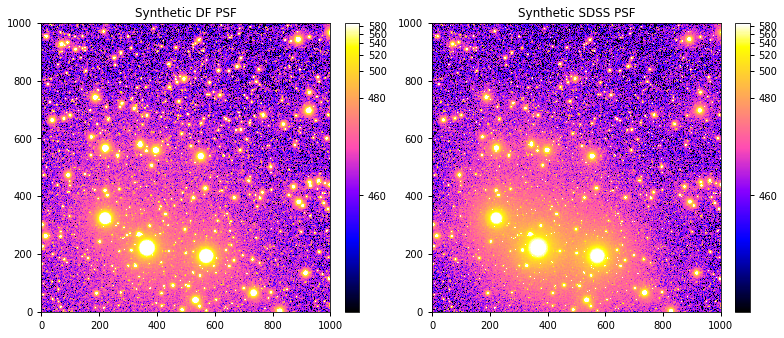

In [65]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))

im = ax1.imshow(image_fit, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax1.set_title("Synthetic DF PSF"); colorbar(im)
im = ax2.imshow(image_sdss, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax2.set_title("Synthetic SDSS PSF"); colorbar(im)

plt.tight_layout()
# plt.savefig("Pics/SDSSvsDF_mock.png",dpi=120)

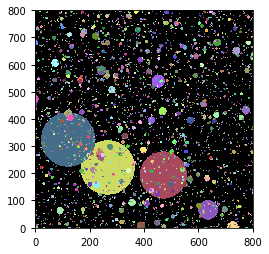

In [51]:
seg_map_cat = fits.getdata('./Measure/Seg_PS_X%dY%d.fits'%(patch_Xmin0, patch_Ymin0))[100:-100,100:-100]#[100:-300,200:-200]
plt.imshow(seg_map_cat, vmin=1, cmap=make_rand_cmap(12000))
mask_base = seg_map_cat>0

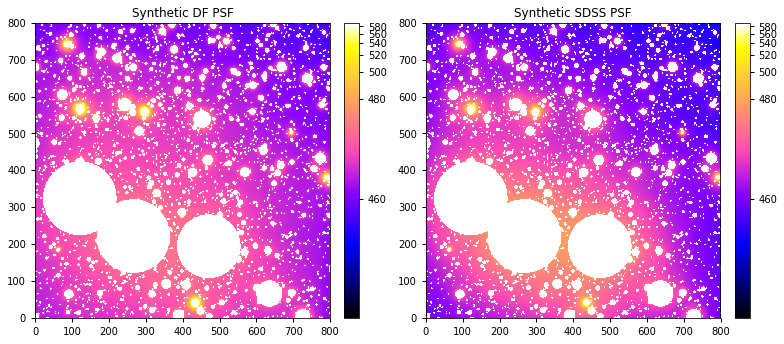

In [52]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
image_fit2 = image_fit.copy()-noise_image
image_fit2[mask_base] = np.nan
im = ax1.imshow(image_fit2, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax1.set_title("Synthetic DF PSF"); colorbar(im)

image_sdss2 = image_sdss.copy()-noise_image
image_sdss2[mask_base] = np.nan
im = ax2.imshow(image_sdss2, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax2.set_title("Synthetic SDSS PSF"); colorbar(im)

plt.tight_layout()
# plt.savefig("Pics/SDSSvsDF_mock.png",dpi=120)

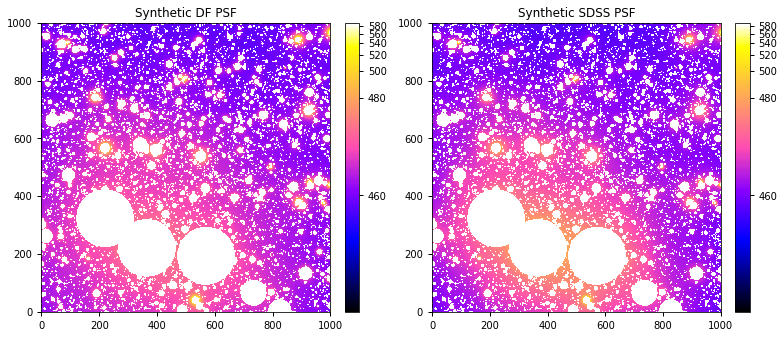

In [75]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,5))
image_fit2 = image_fit.copy()-noise_image
image_fit2[mask_base] = np.nan
im = ax1.imshow(image_fit2, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax1.set_title("Synthetic DF PSF"); colorbar(im)

image_sdss2 = image_sdss.copy()-noise_image
image_sdss2[mask_base] = np.nan
im = ax2.imshow(image_sdss2, vmin=458, vmax=590, norm=norm1, cmap="gnuplot2")
ax2.set_title("Synthetic SDSS PSF"); colorbar(im)

plt.tight_layout()
# plt.savefig("Pics/SDSSvsDF_mock.png",dpi=120)

In [53]:
z_fit = image_fit[~mask_base].ravel()
z_fit2 = image_fit2[~np.isnan(image_fit2)].ravel()

z_sdss = image_sdss[~mask_base].ravel()
z_sdss2 = image_sdss2[~np.isnan(image_sdss2)].ravel()

In [54]:
z_to_I = lambda z: Intensity2SB(z, BKG=459.57, ZP=ZP, pixel_scale=pixel_scale)
I_fit = z_to_I(z_fit)
I_fit2 = z_to_I(z_fit2)
I_sdss = z_to_I(z_sdss)
I_sdss2 = z_to_I(z_sdss2)

good = (np.isfinite(I_fit) & np.isfinite(I_sdss))
good2 = (np.isfinite(I_fit2) & np.isfinite(I_sdss2))
xs=np.linspace(20,35)

/home/qliu/Desktop/PSF/utils.py:65: RuntimeWarning: divide by zero encountered in log10
  I_SB = -2.5*np.log10(I - BKG) + ZP + 2.5 * math.log10(pixel_scale**2)


800x800

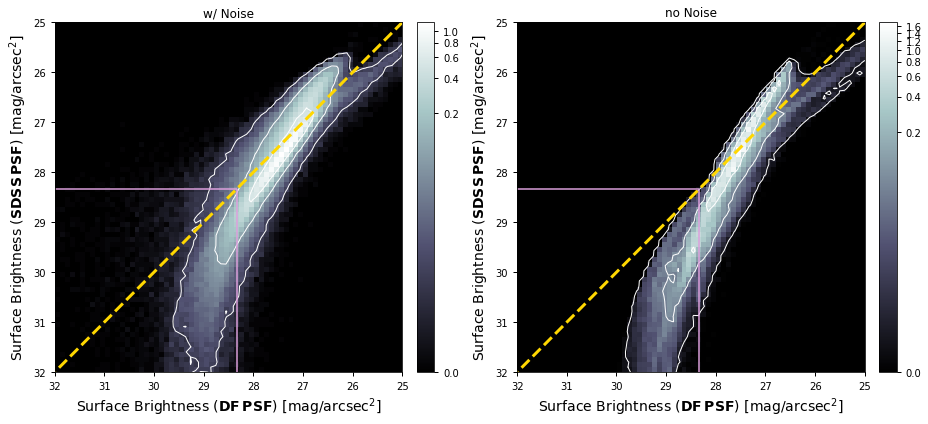

In [55]:
fig = plt.figure(figsize=(13,6))
ax1=plt.subplot(121)
H, xb, yb, im = plt.hist2d(I_fit[good], I_sdss[good], bins=70,
                           range=[[25, 32], [25, 32]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax1.set_title("w/ Noise")

ax2=plt.subplot(122)
H, xb, yb, im = plt.hist2d(I_fit2[good2], I_sdss2[good2], bins=70,
                           range=[[25, 32], [25, 32]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax2.set_title("no Noise")
I_sky = Intensity2SB(2.0, BKG=0, ZP=ZP, pixel_scale=pixel_scale)
for ax in (ax1, ax2):
    ax.vlines(I_sky, 32, I_sky, color='plum')
    ax.hlines(I_sky, 32, I_sky, color='plum')
    ax.plot(xs, xs, ls="--", lw=3, color="gold")

    ax.set_xlabel(r"Surface Brightness ($\bf DF \,PSF$) [mag/arcsec$^2$]")
    ax.set_ylabel(r"Surface Brightness ($\bf SDSS \,PSF$) [mag/arcsec$^2$]")
    ax.set_xlim(32,25)
    ax.set_ylim(32,25)
    
plt.tight_layout()

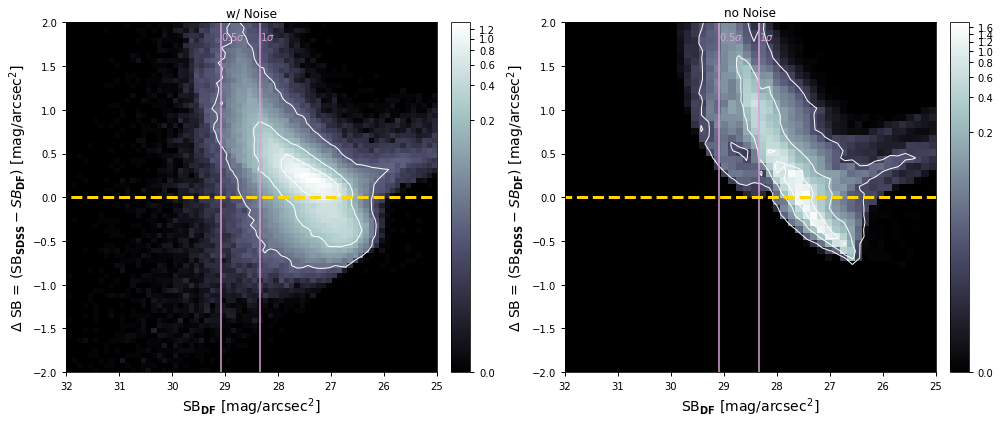

In [56]:
plt.figure(figsize=(14,6))
ax1=plt.subplot(121)
H, xb, yb, im = plt.hist2d(I_fit[good], I_sdss[good]-I_fit[good], bins=70,
                           range=[[25, 32], [-2,2]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax1.set_title("w/ Noise")

ax2=plt.subplot(122)
H, xb, yb, im = plt.hist2d(I_fit2[good2], I_sdss2[good2]-I_fit2[good2], bins=50,
                           range=[[25, 32], [-2,2]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax2.set_title("no Noise")

I_sky = Intensity2SB(2.0, BKG=0, ZP=ZP, pixel_scale=pixel_scale)
I_sky2 = Intensity2SB(1.0, BKG=0, ZP=ZP, pixel_scale=pixel_scale)
for ax in (ax1, ax2):
    ax.vlines(I_sky, -2, 2, color='plum')
    ax.vlines(I_sky2, -2, 2, color='plum')
    ax.text(I_sky, 1.8, "$1\sigma$", color='plum')
    ax.text(I_sky2, 1.8, "$0.5\sigma$", color='plum')
    ax.plot(xs, np.zeros_like(xs), ls="--", lw=3, color="gold")

    ax.set_xlabel(r"SB$_{\bf DF}$ [mag/arcsec$^2$]")
    ax.set_ylabel(r"$\Delta$ SB = (SB$_{\bf SDSS}-SB_{\bf DF}$) [mag/arcsec$^2$]")
    ax.set_xlim(32,25)
    ax.set_ylim(-2,2)
    
plt.tight_layout()

1000x1000

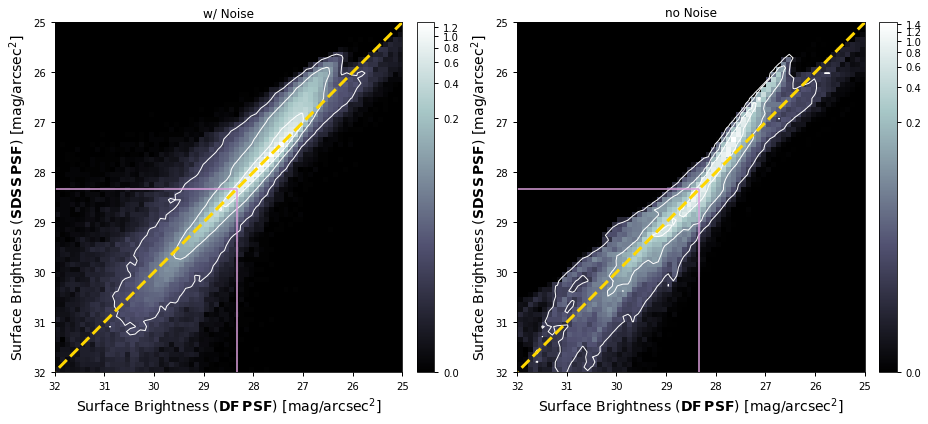

In [88]:
fig = plt.figure(figsize=(13,6))
ax1=plt.subplot(121)
H, xb, yb, im = plt.hist2d(I_fit[good], I_sdss[good], bins=70,
                           range=[[25, 32], [25, 32]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax1.set_title("w/ Noise")

ax2=plt.subplot(122)
H, xb, yb, im = plt.hist2d(I_fit2[good2], I_sdss2[good2], bins=70,
                           range=[[25, 32], [25, 32]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax2.set_title("no Noise")
I_sky = Intensity2SB(2.0, BKG=0, ZP=ZP, pixel_scale=pixel_scale)
for ax in (ax1, ax2):
    ax.vlines(I_sky, 32, I_sky, color='plum')
    ax.hlines(I_sky, 32, I_sky, color='plum')
    ax.plot(xs, xs, ls="--", lw=3, color="gold")

    ax.set_xlabel(r"Surface Brightness ($\bf DF \,PSF$) [mag/arcsec$^2$]")
    ax.set_ylabel(r"Surface Brightness ($\bf SDSS \,PSF$) [mag/arcsec$^2$]")
    ax.set_xlim(32,25)
    ax.set_ylim(32,25)
    
plt.tight_layout()

(24, 33)

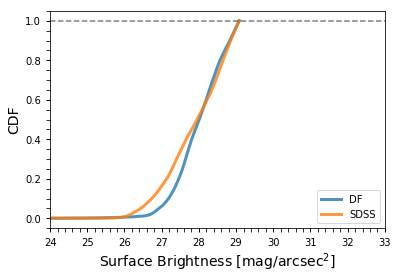

In [139]:
S_fit = I_fit2[good2][I_fit2[good2]<I_sky2]
S_sdss = I_sdss2[good2][I_sdss2[good2]<I_sky2]

# use = (I_fit[good]<29)&(I_sdss[good]<29) & (I_fit[good]>25)&(I_sdss[good]>25)
# S_fit = I_fit[good][use]
# S_sdss = I_sdss[good][use]

plt.plot(np.sort(S_fit), np.cumsum(S_fit)/np.sum(S_fit),lw=3, alpha=0.8, label="DF")
plt.plot(np.sort(S_sdss),
         np.cumsum(S_sdss)/np.sum(S_sdss),lw=3, alpha=0.8, label="SDSS")
plt.legend()
plt.axhline(1, ls="--", color="k", alpha=0.5)
plt.minorticks_on()
plt.xlabel(r"Surface Brightness [mag/arcsec$^2$]")
plt.ylabel("CDF")
plt.xlim(24,33)


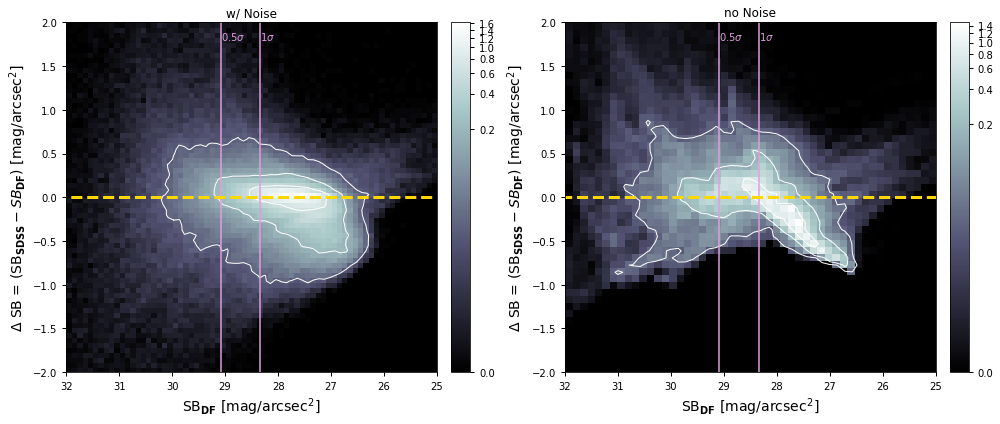

In [140]:
plt.figure(figsize=(14,6))
ax1=plt.subplot(121)
H, xb, yb, im = plt.hist2d(I_fit[good], I_sdss[good]-I_fit[good], bins=70,
                           range=[[25, 32], [-2,2]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax1.set_title("w/ Noise")

ax2=plt.subplot(122)
H, xb, yb, im = plt.hist2d(I_fit2[good2], I_sdss2[good2]-I_fit2[good2], bins=50,
                           range=[[25, 32], [-2,2]], normed=True,
                           norm=ImageNormalize(stretch=AsinhStretch(0.002)), cmap="bone")

plt.contour(H.T, extent=[xb.min(),xb.max(), yb.min(),yb.max()],
            levels=np.quantile(H.ravel(), [0.84, 0.95, 0.99]),
            linewidths=1, colors='w', linestyles='solid')
colorbar(im)
ax2.set_title("no Noise")

I_sky = Intensity2SB(2.0, BKG=0, ZP=ZP, pixel_scale=pixel_scale)
I_sky2 = Intensity2SB(1.0, BKG=0, ZP=ZP, pixel_scale=pixel_scale)
for ax in (ax1, ax2):
    ax.vlines(I_sky, -2, 2, color='plum')
    ax.vlines(I_sky2, -2, 2, color='plum')
    ax.text(I_sky, 1.8, "$1\sigma$", color='plum')
    ax.text(I_sky2, 1.8, "$0.5\sigma$", color='plum')
    ax.plot(xs, np.zeros_like(xs), ls="--", lw=3, color="gold")

    ax.set_xlabel(r"SB$_{\bf DF}$ [mag/arcsec$^2$]")
    ax.set_ylabel(r"$\Delta$ SB = (SB$_{\bf SDSS}-SB_{\bf DF}$) [mag/arcsec$^2$]")
    ax.set_xlim(32,25)
    ax.set_ylim(-2,2)
    
plt.tight_layout()

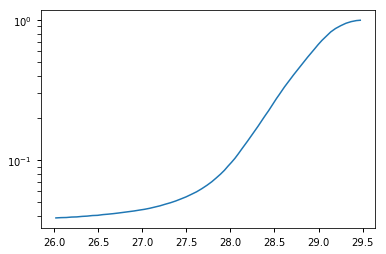

In [141]:
PSF_S09 = pd.read_csv("./web_digit/Slater09.csv")
plt.semilogy(PSF_S09.X, PSF_S09.Y)

(25, 29.5)

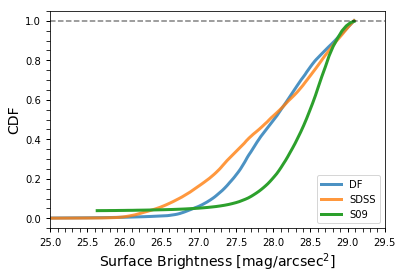

In [145]:
plt.plot(np.sort(S_fit), np.cumsum(S_fit)/np.sum(S_fit),lw=3, alpha=0.8, label="DF")
plt.plot(np.sort(S_sdss),
         np.cumsum(S_sdss)/np.sum(S_sdss),lw=3, alpha=0.8, label="SDSS")
plt.plot(PSF_S09.X - (PSF_S09.X.max()-I_sky2), PSF_S09.Y, lw=3, label="S09")
plt.legend()
plt.axhline(1, ls="--", color="k", alpha=0.5)
plt.minorticks_on()
plt.xlabel(r"Surface Brightness [mag/arcsec$^2$]")
plt.ylabel("CDF")
plt.xlim(25,29.5)